In [1]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker 

In [2]:
n = 1000
dim = 1

mean1 = tf.constant([[0.]])
mean2 = tf.constant([[8.]])
noise_mean = tf.constant([[6.]])

2022-05-05 16:14:24.899028: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-05 16:14:24.899067: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-05-05 16:14:24.899073: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-05-05 16:14:24.899225: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-05-05 16:14:24.899252: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-05-05 16:14:24.899257: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-05-05 16:14:24.900144: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

# All modes

In [232]:
def t_log_prob(x, loc, nv):
    dim = x.shape[1]
    scale = tf.math.sqrt(0.01 * tf.math.sqrt(float(dim)) * tf.eye(dim))
    sigma = scale @ tf.transpose(scale)
    sigma_inv = tf.linalg.inv(sigma)
    
    x_c = tf.matmul(x - loc, sigma_inv, transpose_b=True) # n x dim
    x_c_norm_sq = tf.einsum(
      "ij,ij->i",
      x_c,
      x - loc) # n
    pp = -0.5 * (nv + dim) * tf.math.log(1 + x_c_norm_sq / nv)
    return pp

def t_score(x, loc, nv):
    dim = x.shape[1]
    scale = tf.math.sqrt(0.01 * tf.math.sqrt(float(dim)) * tf.eye(dim))
    sigma = scale @ tf.transpose(scale)
    sigma_inv = tf.linalg.inv(sigma)
    
    x_c = x - loc
    y = tf.matmul(x_c, sigma_inv, transpose_b=True) # n x dim
    y_norm_sq = tf.einsum(
      "ij,ij->i",
      y,
      x_c) # n
    factor = -0.5 * (nv + dim) / (1 + y_norm_sq / nv)
    grad = tf.expand_dims(factor, 1) * 2/nv * y
    return grad

def t_hess(x, loc, nv=7):
    dim = x.shape[1]
    scale = tf.math.sqrt(0.01 * tf.math.sqrt(float(dim)) * tf.eye(dim))
    sigma = scale @ tf.transpose(scale)
    sigma_inv = tf.linalg.inv(sigma)
    
    x_c = x - loc # n x dim
    y = tf.matmul(x_c, sigma_inv, transpose_b=True) # n x dim
    y_norm_sq = tf.einsum("ij,ij->i", y, x_c) # n
    factor1 = tf.expand_dims(-0.5 * (nv + dim) / (1 + y_norm_sq / nv), axis=1) # n x 1
    term1 = 2/nv * tf.expand_dims(factor1, axis=-1) * tf.expand_dims(sigma_inv, axis=0) # n x dim x dim
    
    factor2 = tf.expand_dims(
        tf.expand_dims(0.5 * (nv + dim) / (1 + y_norm_sq / nv)**2, axis=1),
        axis=1
    ) # n x 1 x 1
    outer = tf.expand_dims(x_c, axis=-1) @ tf.expand_dims(x_c, axis=1) # n x dim x dim

    term2 = 4/nv**2 * factor2 * tf.expand_dims(sigma_inv @ sigma_inv, axis=0) @ outer # n x dim x dim
    
    hess = term1 + term2
    return hess


def t_hess_auto(xx, loc):
    xx = tf.stack(mode_list, axis=0)

    with tf.GradientTape() as g2:
        g2.watch(xx)
        with tf.GradientTape() as g1:
            g1.watch(xx)
            pp = t_log_prob(xx, loc[0])
        gg = g1.gradient(pp, xx)
    gg2 = tf.reduce_sum(g2.jacobian(gg, xx), axis=2)
    
    return gg2

In [70]:
tf.random.set_seed(1)

In [71]:
dim = 2

## mixure of gaussians
# k = 1
# delta = 6.
# ratio_sample = 1.
# ratio_target = 0.5

# target, log_prob_fn = models.create_mixture_gaussian_kdim(
#     dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_target)
# proposal_off, log_prob_off_fn = models.create_mixture_gaussian_kdim(
#     dim=dim, k=k, delta=delta, return_logprob=True, ratio=ratio_sample)

## RBM
dh = 2
c_off = tf.concat([tf.ones(2) * 1., tf.zeros(dh-2)], axis=0)
target, log_prob_fn = models.create_rbm(c=0., dx=dim, dh=dh, burnin_number=2000, return_logprob=True)
proposal_off, log_prob_off_fn = models.create_rbm(c=c_off, dx=dim, dh=dh, burnin_number=2000, return_logprob=True)


## t-banana
# nmodes = 20
# nbanana = 10
# ratio_s_var = 5.

# ratio_target = [1/nmodes] * nmodes

# random_weights = tf.exp(tf.random.normal((nmodes,)) * ratio_s_var)
# ratio_sample = random_weights / tf.reduce_sum(random_weights)
# ratio_sample = tf.constant([7.7579454e-05, 4.8678854e-01, 1.9621593e-05, 8.5506955e-04, 6.4088061e-02,
#  3.0733529e-05, 8.0045894e-02, 8.6801274e-06, 6.5268621e-02, 1.0864044e-03,
#  8.0379490e-05, 1.7575960e-04, 7.1048180e-06, 2.5154607e-04, 7.9203119e-06,
#  3.1107475e-04, 6.7057749e-06, 3.7424570e-08, 2.0604947e-01, 9.4840795e-02,])
# print("ratio sample:", ratio_sample.numpy())

# loc = tfp.distributions.Uniform(low=-tf.ones((dim,))*10, high=tf.ones((dim,))*10).sample(nmodes) # uniform in [-20, 20]^d
# # loc = tf.constant([[1.] * dim, [-1.] * dim])
# loc = tf.constant([[  4.363884,   15.967144 ],
#  [-19.275364,   16.7435   ],
#  [ -9.249988,   11.599079 ],
#  [  1.3244209, -15.977497 ],
#  [ -6.122322,   19.227615 ],
#  [  3.3140602, -19.436832 ],
#  [ -3.0468788,   2.5974464],
#  [ -7.928982,   -3.2911835],
#  [  9.438709,    4.6570053],
#  [ 15.773956,  -11.664844 ],
#  [  8.781576,  -13.424449 ],
#  [ -5.3023624,  -2.2030296],
#  [ -7.5855064,   1.1301193],
#  [ 11.219397,    5.4884872],
#  [ 11.858902,   -2.2964   ],
#  [  5.84301,    19.939896 ],
#  [ 10.34234,     5.44598  ],
#  [-19.316349,    5.493574 ],
#  [ -3.2042732,  13.097462 ],
#  [-16.813465,   12.329731 ]])
# print("means", loc)

# b = 0.003 # 0.03
# target, log_prob_fn = models.create_mixture_t_banana(dim=dim, ratio=ratio_target, loc=loc, b=b,
#     nbanana=nbanana, return_logprob=True)
# proposal_off, log_prob_off_fn = models.create_mixture_t_banana(dim=dim, ratio=ratio_sample, loc=loc, b=b,
#     nbanana=nbanana, return_logprob=True)


## t-mixture
# nmodes = 3
# t_std = .1
# ratio_s_var = 1.

# ratio_target = [1/nmodes] * nmodes

# random_weights = tf.exp(tf.random.normal((nmodes,)) * ratio_s_var)
# ratio_sample = random_weights / tf.reduce_sum(random_weights)
# print("ratio sample:", ratio_sample.numpy())

# loc = tf.constant([[5.] * dim, [-5.] * dim, [5, -5]])
# print("means", loc)

# target, log_prob_fn = models.create_mixture_t(dim=dim, ratio=ratio_target, loc=loc, std=t_std,
#     return_logprob=True)
# proposal_off, log_prob_off_fn = models.create_mixture_t(dim=dim, ratio=ratio_sample, loc=loc, std=t_std,
#     return_logprob=True)


## scaled Gaussian 
# ratio_t = 0.5
# ratio_s = 0.3
# target, log_prob_fn = models.create_mixture_gaussian_scaled(ratio=ratio_t, return_logprob=True)
# proposal_off, log_prob_off_fn = models.create_mixture_gaussian_scaled(ratio=ratio_s, return_logprob=True)

In [72]:
n = 1000
samples_on = target.sample(n)
samples_on_df = pd.DataFrame({f"x{i}": samples_on[:, i] for i in range(dim)})
samples_on_df["type"] = "on"

samples_off = proposal_off.sample(n)
samples_off_df = pd.DataFrame({f"x{i}": samples_off[:, i] for i in range(dim)})
samples_off_df["type"] = "off"

samples_df = pd.concat([samples_on_df, samples_off_df], ignore_index=True)

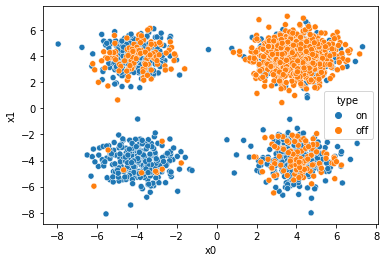

In [73]:
_ = sns.scatterplot(data=samples_df, x="x0", y="x1", hue="type")
# _ = plt.axis(xmax=10., xmin=-10., ymax=10., ymin=-10.)

In [74]:
ntrain = n // 2
threshold = 1.

samples_init = samples_off
# samples_init = samples_on

sample_off_train, sample_off_test = samples_init[:ntrain, ], samples_init[ntrain:, ]

# start_pts = sample_off_train
start_pts = tf.concat([
    sample_off_train[:(ntrain//2)], 
    tf.random.uniform(shape=(ntrain//2, dim), minval=-10., maxval=10.)], axis=0)

mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold)

In [75]:
mode_list, inv_hess_list

([<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 4.,  4., -4.,  0.], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([4., 4., 4., 0.], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-4.,  4.,  4.,  0.], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-4., -4., -4.,  0.], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-4.,  4., -4.,  0.], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 4., -4., -4.,  0.], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 4., -4.,  4.,  0.], dtype=float32)>,
  <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-4., -4.,  4.,  0.], dtype=float32)>],
 [<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
  array([[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]], dtype=float32)>,
  <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
  array([[1., 0., 0., 0.],
         [0., 

In [76]:
proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)

In [77]:
_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

In [78]:
std = [1., .9, 1.286]

In [79]:
T = 50

mh = MCMCKernel(log_prob=log_prob_fn)
mh.run(steps=T, std=std, x_init=sample_off_train, ind_pair_list=ind_pair_list, **proposal_dict)

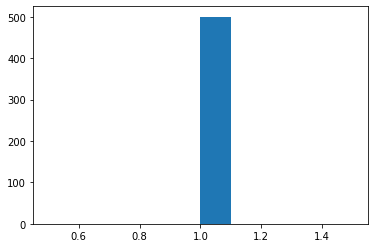

In [83]:
if len(mh.if_accept.shape) == 3:
    xx = (np.sum(mh.if_accept.numpy()[0], axis=0) > 0.).astype(np.float32)
else:
    xx = (np.sum(mh.if_accept.numpy(), axis=0) > 0.).astype(np.float32)
_ = plt.hist(xx)

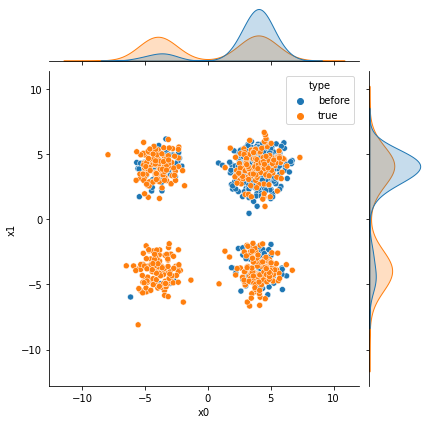

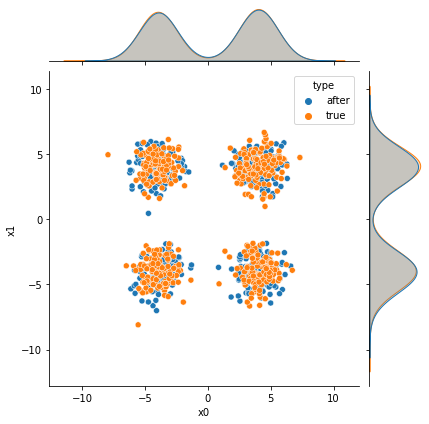

In [86]:
if len(mh.if_accept.shape) == 3:
    x_all = mh.x[0] #!
else:
    x_all = mh.x
    
x_0 = x_all[0, :, :].numpy()
x_t = x_all[-1, :, :].numpy()

x0_df = pd.DataFrame({f"x{i}": x_0[:, i] for i in range(dim)})
x0_df["type"] = "before"

xt_df = pd.DataFrame({f"x{i}": x_t[:, i] for i in range(dim)})
xt_df["type"] = "after"

sample_on_df = pd.DataFrame({f"x{i}": samples_on.numpy()[:x_0.shape[0], i] for i in range(dim)})
sample_on_df["type"] = "true"

x0_df = pd.concat([x0_df, sample_on_df], ignore_index=True)
xt_df = pd.concat([xt_df, sample_on_df], ignore_index=True)

# fig = plt.figure(figsize=(14, 5))
_ = sns.jointplot(data=x0_df, x="x0", y="x1", hue="type",
#                   xlim=(-4., 10.), 
#                   ylim=(-7, 7),
 )

_ = sns.jointplot(data=xt_df, x="x0", y="x1", hue="type",
#                   xlim=(-4., 10.), 
#                   ylim=(-7, 7),
 )

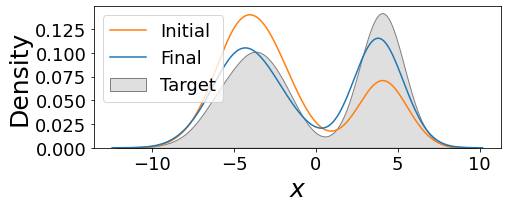

In [290]:
res_df = pd.concat([x0_df, xt_df, sample_on_df], ignore_index=True)
res_df.type.replace({"true": "Target", "init": "Initial", "final": "Final"}, inplace=True)

fig = plt.figure(figsize=(7, 3))
sns.kdeplot(data=res_df.loc[res_df.type.isin(["Initial"])], x="x0", 
#             fill=True, 
            color="tab:orange",
            label="Initial",
            )
sns.kdeplot(data=res_df.loc[res_df.type.isin(["Final"])], x="x0", 
#             fill=True, 
            color="tab:blue",
            label="Final"
            )
sns.kdeplot(data=res_df.loc[res_df.type.isin(["Target"])], x="x0", 
            fill=True, 
            color="grey",
            label="Target",
            )

plt.xlabel("$x$", fontsize=25)
plt.ylabel("Density", fontsize=25)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.tight_layout()
# fig.savefig("figs/paper/bimodal_density_plot.pdf")

In [291]:
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, n//2)

In [71]:
multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
multinom_one_sample = multinom_samples[0, :]

2022-05-04 16:38:39.933343: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [292]:
_, p_val_no_pert = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_0, multinom_samples=multinom_one_sample)

_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
print("before: ", p_val_no_pert, "\nafter:", p_val)

before:  0.024968789013732832 
after: 0.0


# Repeat experiment

In [50]:
def repeat_experiment(n, nrep, target_dist, sample_dist):
    jump_ls = np.linspace(0.5, 1.5, 11).tolist()
    
    ntrain = n // 2
    threshold = 1.

    num_boot = 800
    alpha = 0.05
    T = 10
    
    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=target_dist, kernel=kernel)
    bootstrap = Bootstrap(ksd, n-ntrain)
    
    multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
    
    # generate samples
    off_sample_all = sample_dist.sample((nrep, n))

    p_val_list = []
    jump_ratio_list = []
    iterator = trange(nrep)
    for i in iterator:
        # sample data
        samples_init = off_sample_all[i, :]
        
        sample_init_train, sample_off_test = samples_init[:ntrain, ], samples_init[ntrain:, ]
#         start_pts = sample_off_train
        start_pts = tf.concat([
            sample_init_train[:(ntrain//2)], 
            tf.random.uniform(shape=(ntrain//2, dim), minval=-10., maxval=10.)], axis=0)
        
        # find modes
        mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=None, threshold=threshold)
        off_sample = off_sample_all[i, :]
        
        proposal_dict = mcmc.prepare_proposal_input_all(mode_list=mode_list, inv_hess_list=inv_hess_list)
        _, ind_pair_list = pairwise_directions(mode_list, return_index=True)

        # find best jump scale
        best_pksd = 0.
        for j, jump in enumerate(jump_ls):
            # loop through jump scales
            iterator.set_description(f"Jump scale [{j+1} / {len(jump_ls)}]]")

            # run dynamic for T steps
            mh = MCMCKernel(log_prob=log_prob_fn)
            mh.run(steps=T, std=jump, x_init=sample_init_train, ind_pair_list=ind_pair_list, **proposal_dict)

            # compute ksd
            x_t = mh.x[-1, :, :].numpy()
            _, ksd_val = ksd.h1_var(X=x_t, Y=tf.identity(x_t), return_scaled_ksd=True)
            ksd_val = ksd_val.numpy()

            # update if ksd is larger
            if (ksd_val > best_pksd) or (j == 0):
                best_jump = jump
                best_pksd = ksd_val
                best_proposal_dict = proposal_dict
        
        # mh perturbation
        mh = MCMCKernel(log_prob=log_prob_fn)
        mh.run(steps=T, std=best_jump, x_init=sample_off_test, 
               ind_pair_list=ind_pair_list, **proposal_dict)
        x_t = mh.x[-1, :, :]

        # compute p-value
        kernel = IMQ(med_heuristic=True)
        ksd = KSD(target=target_dist, kernel=kernel)
        bootstrap = Bootstrap(ksd, n)

        multinom_one_sample = multinom_samples[i, :]

        _, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)

        p_val_list.append(p_val)
        jump_ratio_list.append(best_jump)
        
    res = pd.DataFrame({"pval": p_val_list, "jump": jump_ratio_list})
    return res

In [51]:
res_df = repeat_experiment(n=n, nrep=100, target_dist=target, sample_dist=proposal_off)

  0%|          | 0/100 [00:00<?, ?it/s]

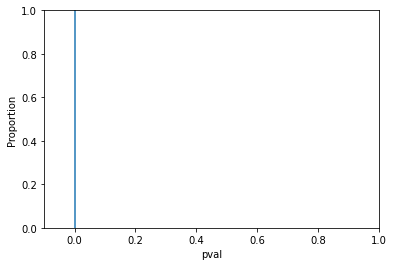

In [52]:
sns.ecdfplot(data=res_df, x="pval")
_ = plt.axis(xmin=-0.1, xmax=1.)

mean jump scale: 1.2860000000000003


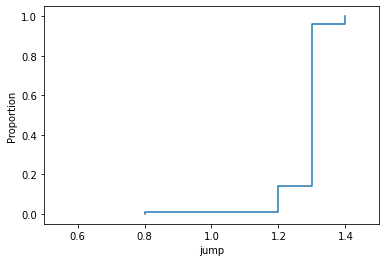

In [53]:
print("mean jump scale:", res_df.jump.mean())
sns.ecdfplot(data=res_df, x="jump")
_ = plt.axis(xmin=0.5, xmax=1.5, ymin=-0.05, ymax=1.05)

In [ ]:
res_df_ordered = repeat_experiment(n=n//2, nrep=100, target_dist=target, sample_dist=target)

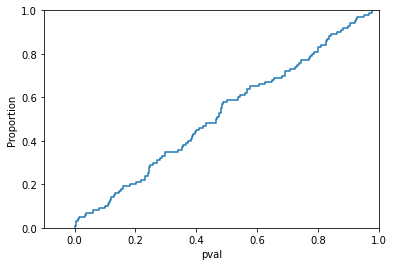

In [25]:
sns.ecdfplot(data=res_df_ordered, x="pval")
_ = plt.axis(xmin=-0.1, xmax=1.)

# Repeat RBM experiment

In [ ]:
def repeat_experiment_rbm(nrep, B_scale):    
    off_target2, log_prob_off_fn2 = models.create_rbm(
        B_scale=B_scale, c=c_loc_off, dx=dim, dh=dh, return_logprob=True, burnin_number=2000)

    num_boot = 800
    alpha = 0.05

    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=off_target2, kernel=kernel)
    bootstrap = Bootstrap(ksd, n)
    
    multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
    multinom_one_sample = multinom_samples[0, :]
    
    p_val_list = []
    for i in trange(nrep):
        off_sample2 = off_target2.sample(n)
        syn_sample = off_sample2 #!
    
        kernel = IMQ(med_heuristic=True)
        ksd = KSD(target=off_target2, kernel=kernel)
        bootstrap = Bootstrap(ksd, n)
        
        multinom_one_sample = multinom_samples[i, :]
        
        _, p_val2 = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=off_sample2, multinom_samples=multinom_one_sample)
        _, p_val_sync = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=syn_sample, multinom_samples=multinom_one_sample)

        p_val_list.append((p_val2, "builtin"))
        p_val_list.append((p_val_sync, "synthetic"))
        
    res = pd.DataFrame(p_val_list, columns=["pval", "type"])
    return res